In [ ]:
# Mounting Google Drive to get zip file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#unzipping file
!unzip '/content/drive/MyDrive/Datasets/Fruits_Vegetables.zip' -d '/content/Fruits & Veg Dataset'

Archive:  /content/drive/MyDrive/Datasets/Fruits_Vegetables.zip
   creating: /content/Fruits & Veg Dataset/Fruits_Vegetables/test/
   creating: /content/Fruits & Veg Dataset/Fruits_Vegetables/test/apple/
  inflating: /content/Fruits & Veg Dataset/Fruits_Vegetables/test/apple/Image_1.jpg  
  inflating: /content/Fruits & Veg Dataset/Fruits_Vegetables/test/apple/Image_10.jpg  
  inflating: /content/Fruits & Veg Dataset/Fruits_Vegetables/test/apple/Image_2.jpg  
  inflating: /content/Fruits & Veg Dataset/Fruits_Vegetables/test/apple/Image_3.jpg  
  inflating: /content/Fruits & Veg Dataset/Fruits_Vegetables/test/apple/Image_4.jpg  
  inflating: /content/Fruits & Veg Dataset/Fruits_Vegetables/test/apple/Image_5.jpg  
  inflating: /content/Fruits & Veg Dataset/Fruits_Vegetables/test/apple/Image_6.JPG  
  inflating: /content/Fruits & Veg Dataset/Fruits_Vegetables/test/apple/Image_7.jpg  
  inflating: /content/Fruits & Veg Dataset/Fruits_Vegetables/test/apple/Image_8.jpg  
  inflating: /content

In [ ]:
# importing all the necessary libraries
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization,GlobalAvgPool2D, Rescaling
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import cv2
import random
import shutil
import glob
import pandas as pd

<h1>Pre-processing Data</h1>
Since the dataset that is being used in this project has already separated test, train & validation datasets with all fruits classified into files, we can skip the labelling and train-test-split steps.

In [ ]:
# pre-processing od data
IMG_HEIGHT, IMG_WIDTH = 224, 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

# getting all the necessary directories
train_data_dir = '/content/Fruits & Veg Dataset/Fruits_Vegetables/train'
test_data_dir = '/content/Fruits & Veg Dataset/Fruits_Vegetables/test'
val_data_dir = '/content/Fruits & Veg Dataset/Fruits_Vegetables/validation'

# from folders to dataset
train_ds = keras.utils.image_dataset_from_directory(
    train_data_dir,
    image_size=IMG_SIZE,
    batch_size=32,
    shuffle=True,
    validation_split = False
)

val_ds = keras.utils.image_dataset_from_directory(
    val_data_dir,
    image_size=IMG_SIZE,
    batch_size=32,
    shuffle=True,
    validation_split = False
)

test_ds = keras.utils.image_dataset_from_directory(
    test_data_dir,
    image_size=IMG_SIZE,
    batch_size=32,
    shuffle=True,
    validation_split = False
)

Found 3115 files belonging to 36 classes.
Found 351 files belonging to 36 classes.
Found 359 files belonging to 36 classes.


<h1>Building a Model</h1>
Since this is a image classification model on a larger scale, we will be using an AlexNet model, but with some layers taken out to simply the model & save computational power, since the model already has a huge number of parameters

<img>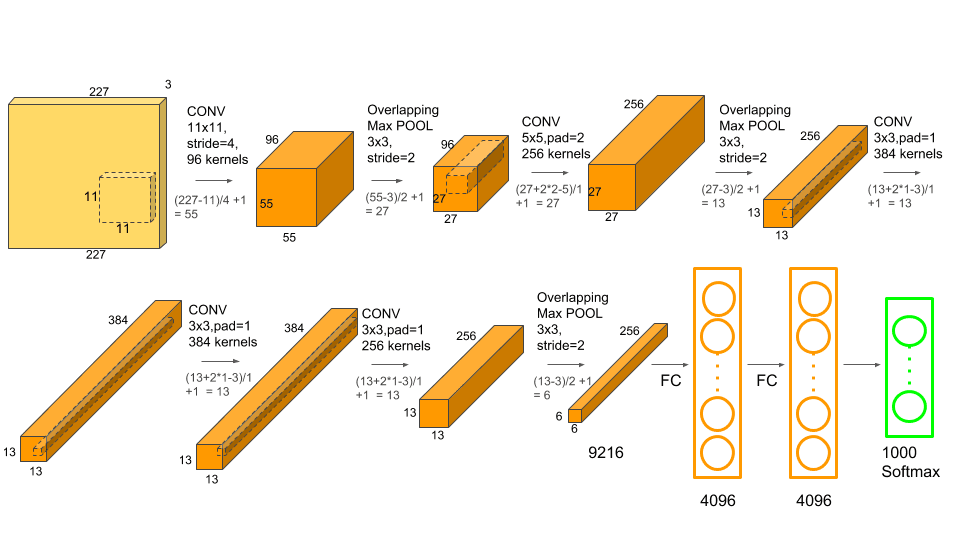

The changes implemented are:


*   <b>Rescaling</b> : To normalize the values of the pixels of the images to [0,1]
*   <b>Dropout</b> : Added a dropout layer before flattening and between the two FC layers to help prevent overfitting
*   <b>Removal of 2nd FC layer</b> : Removing the 2nd fully connected layer to somewhat simplify the model





In [ ]:
model = Sequential()

# Rescaling to normalize all images
model.add(Rescaling((1./255), input_shape=(224, 224, 3)))

# First Convolution Layer with Activation Layer and MaxPooling
model.add(Conv2D(filters = 96, kernel_size = (11, 11), strides = 4, padding = 'same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPool2D(pool_size = (3,3), strides = 2))

# Second Convolution Layer with Activation Layer and MaxPooling
model.add(Conv2D(filters = 256, kernel_size = (5, 5), strides = 1, padding = 'same', activation='relu'))
model.add(MaxPool2D(pool_size = (3,3), strides = 2))

# Third Convolution Layer with Activation Layer
model.add(Conv2D(filters = 384, kernel_size = (3, 3), strides = 1, padding = 'same', activation='relu'))

# Fourth Convolution Layer with Activation Layer
model.add(Conv2D(filters = 384, kernel_size = (3, 3), strides = 1, padding = 'same', activation='relu'))

# Fifth Convolution Layer with Activation Layer and MaxPooling
model.add(Conv2D(filters = 256, kernel_size = (3, 3), strides = 1, padding = 'same', activation='relu'))
model.add(MaxPool2D(pool_size = (3,3), strides = 2))

# Dropout layer to prevent overfitting
model.add(Dropout(rate=0.25))

# Flatten the feature maps
model.add(Flatten())

# Full Connected Layers
model.add(Dense(units = 4096, activation = 'relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units = 36, activation = 'sigmoid'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 56, 56, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 27, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 36)                  │         147,492 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,647,524 (158.87 MB)

 Trainable params: 41,647,524 (158.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compiling Model using Adam Optimizer & BCE loss
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
def modelFit(train_data, val_data):
  # Early Stopping of the model's accuracy and loss values do not improve
  es = EarlyStopping(monitor = 'val_loss', mode = 'min',
                     patience = 2,
                     restore_best_weights = True,
                     verbose = 1)

  # Saves the best model
  mc = ModelCheckpoint('best_model.keras', monitor = 'val_loss',
                       mode = 'min', save_best_only = True)

  # Reducing learning rate when validation loss stops improving to help with convergence
  reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                factor = 0.3,
                                patience = 2,
                                min_lr = 1e-5,
                                mode = 'min',
                                verbose = 1)

  # Training the data in 50 epochs (max) with 10 batch size
  history = model.fit(train_data,
                      validation_data = val_data,
                      epochs = 50,
                      batch_size = 32,
                      callbacks = [es, mc, reduce_lr])

  return history

In [ ]:
k_fold = 3
def CV_training (train_dataset, val_dataset):
  cv_histories = []
  for i in range (0, k_fold):
    print("Training on fold: ", i+1)
    cv_histories.append(modelFit(train_dataset, val_dataset))

  return cv_histories

cv_results = CV_training(train_ds, val_ds)

Training on fold:  1
Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 94s 845ms/step - accuracy: 0.0595 - loss: 3.4624 - val_accuracy: 0.2165 - val_loss: 2.6009 - learning_rate: 1.0000e-04
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 70s 708ms/step - accuracy: 0.2077 - loss: 2.6977 - val_accuracy: 0.3846 - val_loss: 1.9548 - learning_rate: 1.0000e-04
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 77s 661ms/step - accuracy: 0.2679 - loss: 2.3690 - val_accuracy: 0.4872 - val_loss: 1.6958 - learning_rate: 1.0000e-04
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 66s 675ms/step - accuracy: 0.3180 - loss: 2.2026 - val_accuracy: 0.5442 - val_loss: 1.5032 - learning_rate: 1.0000e-04
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 65s 662ms/step - accuracy: 0.3683 - loss: 2.0482 - val_accuracy: 0.6011 - val_loss: 1.3408 - learning_rate: 1.0000e-04
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 67s 675ms/step - accuracy: 0.4282 - loss: 1.8382 - val_accuracy: 0.6268 - val_loss: 1.2013 - learning_rate: 1.0000e-04
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━

<h1>Umm.... I did an oopsie</h1>

So... I wanted to implement a 3-fold training, but I didn't code it right & the 2nd/3rd fold always ended up taking the best model from the previous fold.

Since I'm using Google Colab & I do not want to go through the hassle of retraining, I'm going to combine all the values into one fold & do the plots that way.

In [ ]:
def acc_results(results):
  i = 0
  all_train_acc = []
  all_train_loss = []
  all_val_acc = []
  all_val_loss = []
  for fold in cv_results:
    print('Val_Acc Folder: '+ str(i) + ' = ', max(fold.history['val_accuracy']))
    print('Val_Loss Folder: '+ str(i) + ' = ', min(fold.history['val_loss']))

    #transferring the losses & accuracy values from all the folds into one variable
    all_train_acc.extend(fold.history['accuracy'])
    all_train_loss.extend(fold.history['loss'])
    all_val_acc.extend(fold.history['val_accuracy'])
    all_val_loss.extend(fold.history['val_loss'])

    i += 1

  # converting to numpy array for ease of plotting
  all_train_acc, all_train_loss, all_val_acc, all_val_loss = np.array(all_train_acc), np.array(all_train_loss), np.array(all_val_acc), np.array(all_val_loss)
  return all_train_acc, all_train_loss, all_val_acc, all_val_loss

all_train_acc, all_train_loss, all_val_acc, all_val_loss = acc_results(cv_results)

Val_Acc Folder: 0 =  0.8945869207382202
Val_Loss Folder: 0 =  0.4866270422935486
Val_Acc Folder: 1 =  0.94017094373703
Val_Loss Folder: 1 =  0.24965117871761322
Val_Acc Folder: 2 =  0.94017094373703
Val_Loss Folder: 2 =  0.22038625180721283


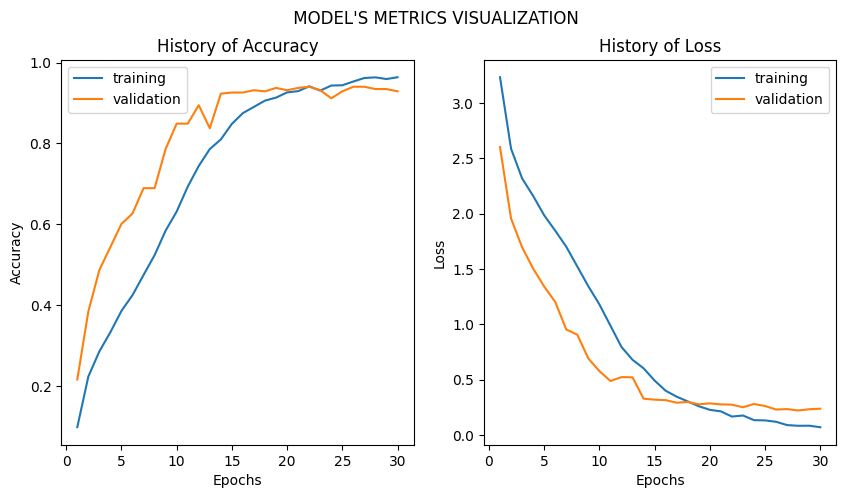

In [ ]:
def Acc_Loss_Plot (acc, val_acc, loss, val_loss):
  fig, (ax1, ax2) = plt.subplots(1,2, figsize= (10,5))
  fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

  ax1.plot(range(1, len(acc) + 1), acc)
  ax1.plot(range(1, len(val_acc) + 1), val_acc)
  ax1.set_title('History of Accuracy')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Accuracy')
  ax1.legend(['training', 'validation'])


  ax2.plot(range(1, len(loss) + 1), loss)
  ax2.plot(range(1, len(val_loss) + 1), val_loss)
  ax2.set_title('History of Loss')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Loss')
  ax2.legend(['training', 'validation'])
  plt.show()

Acc_Loss_Plot(all_train_acc, all_val_acc, all_train_loss, all_val_loss)

In [ ]:
loaded_model = keras.models.load_model('best_model.keras')
loaded_model.compile (optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

loss, accuracy = loaded_model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 838ms/step - accuracy: 0.9311 - loss: 0.2829
Test Accuracy: 93.59%
